In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [5]:
#pip install pandas mlxtend
#!pip install pandas-profiling
#!pip install --upgrade pandas_profiling

In [6]:
import pandas as pd
import numpy as np
import io

import matplotlib.pyplot as plt
import seaborn as sns

from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import mlxtend as ml

print(f'Libraries loaded!')

Libraries loaded!


In [8]:
df_initial = pd.read_csv('../input/mba-tugas/BreadBasket_DMS.csv', header = 0)
df_initial.head()

,Date,Time,Transaction,Item
0,2016-10-30,09:58:11,1,Bread
1,2016-10-30,10:05:34,2,Scandinavian
2,2016-10-30,10:05:34,2,Scandinavian
3,2016-10-30,10:07:57,3,Hot chocolate
4,2016-10-30,10:07:57,3,Jam


In [9]:
display(df_initial.info())

# Descriptive statistics of the data
display(df_initial.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21293 entries, 0 to 21292
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Date         21293 non-null  object
 1   Time         21293 non-null  object
 2   Transaction  21293 non-null  int64 
 3   Item         21293 non-null  object
dtypes: int64(1), object(3)
memory usage: 665.5+ KB


None

,Transaction
count,21293.000000
mean,4951.990889
std,2787.758400
min,1.000000
25%,2548.000000
50%,5067.000000
75%,7329.000000
max,9684.000000


In [10]:
print('  ' * 10 + " Display information about column types and number of null values " + '  ' * 10 )
print('--' * 50)

tab_info = pd.DataFrame(df_initial.dtypes).T.rename(index={0:'column type'})
tab_info = tab_info.append(pd.DataFrame(df_initial.isnull().sum()).T.rename(index={0:'null values'}))
tab_info = tab_info.append(pd.DataFrame(df_initial.isnull().sum()/df_initial.shape[0]*100).T.rename(index={0:'null values (%)'}))

if(any(df_initial.isnull().any())):
    print()
    display(tab_info)
else:
    print('NO missing data')

                     Display information about column types and number of null values                     
----------------------------------------------------------------------------------------------------
NO missing data


In [11]:
missing_value = ["NaN", "NONE", "None", "Nil", "nan", "none", "nil", 0]

print('---------------------------------------------------------')
print("There are {0} 'hidden' missing values in the 'Item'column.".format(len(df_initial[df_initial.Item.isin(missing_value)])))
print("There are {0} 'hidden' missing values in the 'Transaction'.".format(len(df_initial[df_initial.Transaction.isin(missing_value)])))
print('---------------------------------------------------------')
df_initial[df_initial.Item.isin(missing_value)].head()


---------------------------------------------------------
There are 786 'hidden' missing values in the 'Item'column.
There are 0 'hidden' missing values in the 'Transaction'.
---------------------------------------------------------


,Date,Time,Transaction,Item
26,2016-10-30,10:27:21,11,NONE
38,2016-10-30,10:34:36,15,NONE
39,2016-10-30,10:34:36,15,NONE
66,2016-10-30,11:05:30,29,NONE
80,2016-10-30,11:37:10,37,NONE


In [12]:
bread = df_initial.drop(df_initial[df_initial.Item == "NONE"].index)
print("Number of rows: {0:,} (original 21,293) ".format(len(bread)))
print('----------------------------------------')
bread.head()

# After removing the missing values, the number of rows left is 20,507 (original 21,293 minus 786 missing)

Number of rows: 20,507 (original 21,293) 
----------------------------------------


,Date,Time,Transaction,Item
0,2016-10-30,09:58:11,1,Bread
1,2016-10-30,10:05:34,2,Scandinavian
2,2016-10-30,10:05:34,2,Scandinavian
3,2016-10-30,10:07:57,3,Hot chocolate
4,2016-10-30,10:07:57,3,Jam


In [13]:
bread['Datetime'] = pd.to_datetime(bread['Date'] + ' ' + bread['Time'])
bread = bread[["Datetime", "Transaction", "Item"]].set_index("Datetime")
bread.head()

,Transaction,Item
Datetime,,
2016-10-30 09:58:11,1,Bread
2016-10-30 10:05:34,2,Scandinavian
2016-10-30 10:05:34,2,Scandinavian
2016-10-30 10:07:57,3,Hot chocolate
2016-10-30 10:07:57,3,Jam


In [14]:
bread["Hour"] = bread.index.hour
bread["Weekday"] = bread.index.weekday + 1

bread.head()

,Transaction,Item,Hour,Weekday
Datetime,,,,
2016-10-30 09:58:11,1,Bread,9,7
2016-10-30 10:05:34,2,Scandinavian,10,7
2016-10-30 10:05:34,2,Scandinavian,10,7
2016-10-30 10:07:57,3,Hot chocolate,10,7
2016-10-30 10:07:57,3,Jam,10,7


In [15]:
total_items = len(bread)
total_days = len(np.unique(bread.index.date))
total_months = len(np.unique(bread.index.month))
average_items = int(total_items / total_days)
unique_items = bread.Item.unique().size

print("Total unique_items: {} sold by the Bakery".format(unique_items))
print('-----------------------------')
print("Total sales: {} items sold in {} days throughout {} months".format(total_items, total_days, total_months))
print('-----------------------------')
print("Average_items daily sales: {}".format(average_items))

Total unique_items: 94 sold by the Bakery
-----------------------------
Total sales: 20507 items sold in 159 days throughout 7 months
-----------------------------
Average_items daily sales: 128


In [16]:
counts = bread.Item.value_counts()
percent = bread.Item.value_counts(normalize=True).mul(100).round(1).astype(str) + '%'
top_10 = pd.DataFrame({'counts': counts, '%': percent})[:10]

print('-----------------------------')
print('Top 10 items')
print('-----------------------------')
display(top_10)

-----------------------------
Top 10 items
-----------------------------


,counts,%
Coffee,5471,26.7%
Bread,3325,16.2%
Tea,1435,7.0%
Cake,1025,5.0%
Pastry,856,4.2%
Sandwich,771,3.8%
Medialuna,616,3.0%
Hot chocolate,590,2.9%
Cookies,540,2.6%
Brownie,379,1.8%


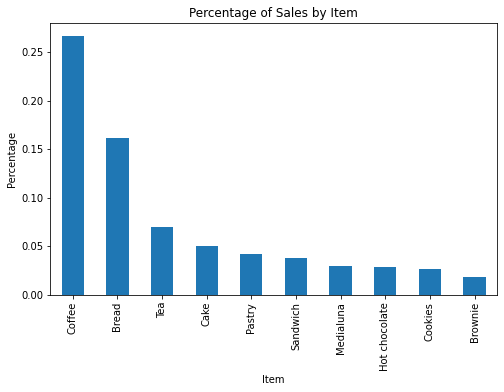

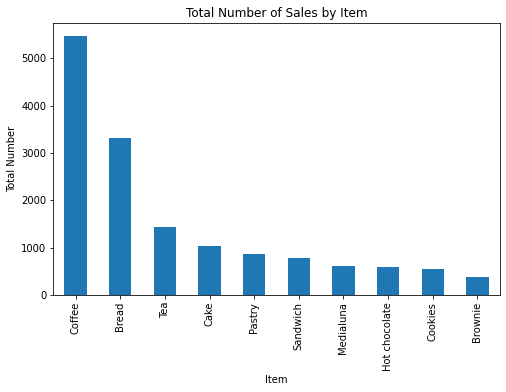

In [17]:
plt.figure(figsize=(8,5))
bread.Item.value_counts(normalize=True)[:10].plot(kind="bar", title="Percentage of Sales by Item").set(xlabel="Item", ylabel="Percentage")
plt.show()

# Rank by value
plt.figure(figsize=(8,5))
bread.Item.value_counts()[:10].plot(kind="bar", title="Total Number of Sales by Item").set(xlabel="Item", ylabel="Total Number")
plt.show()

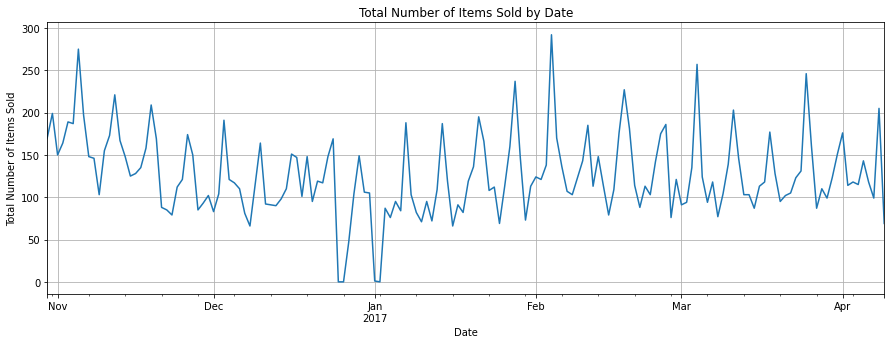

In [18]:
bread["Item"].resample("D").count().plot(figsize=(15,5), grid=True, title="Total Number of Items Sold by Date").set(xlabel="Date", ylabel="Total Number of Items Sold")
plt.show()

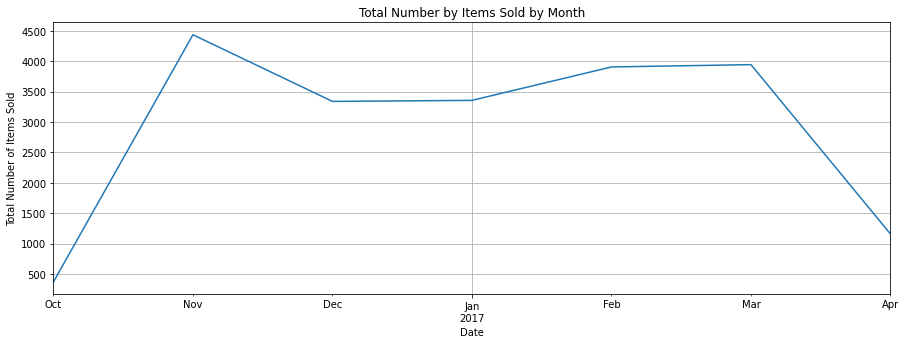

In [19]:
bread["Item"].resample("M").count().plot(figsize=(15,5), grid=True, title="Total Number by Items Sold by Month").set(xlabel="Date", ylabel="Total Number of Items Sold")
plt.show()

           Item
Hour           
1      0.006289
7      0.150943
8      4.056604
9     12.364780
10    16.767296
11    19.509434
12    17.949686
13    16.459119
14    16.603774
15    13.301887
16     8.446541
17     2.314465
18     0.515723
19     0.301887
20     0.138365
21     0.018868
22     0.050314
23     0.018868


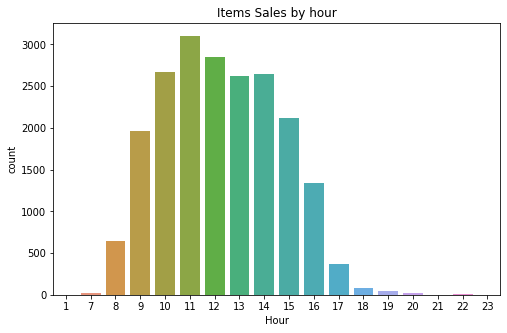

In [20]:
bread_groupby_hour = bread.groupby("Hour").agg({"Item": lambda item: item.count()/total_days})
print(bread_groupby_hour)

# Plot items sold by hour
plt.figure(figsize=(8,5))
sns.countplot(x='Hour',data=bread)
plt.title('Items Sales by hour')
plt.show()

In [21]:
bread_groupby_weekday = bread.groupby("Weekday").agg({"Item": lambda item: item.count()})
bread_groupby_weekday.head()

,Item
Weekday,
1,2324
2,2392
3,2321
4,2646
5,3124


In [22]:
import datetime 
daterange = pd.date_range(datetime.date(2016, 10, 30), datetime.date(2017, 4, 9))

monday = 0
tuesday = 0
wednesday = 0
thursday = 0
friday = 0
saturday = 0
sunday = 0

for day in np.unique(bread.index.date):
    if day.isoweekday() == 1:
        monday += 1
    elif day.isoweekday() == 2:
        tuesday += 1
    elif day.isoweekday() == 3:
        wednesday += 1
    elif day.isoweekday() == 4:
        thursday += 1        
    elif day.isoweekday() == 5:
        friday += 1        
    elif day.isoweekday() == 6:
        saturday += 1        
    elif day.isoweekday() == 7:
        sunday += 1        
        
all_weekdays = monday + tuesday + wednesday + thursday + friday + saturday + sunday

print("monday = {0}, tuesday = {1}, wednesday = {2}, thursday = {3}, friday = {4}, saturday = {5}, sunday = {6}, total = {7}".format(monday, tuesday, wednesday, thursday, friday, saturday, sunday, all_weekdays))

monday = 21, tuesday = 23, wednesday = 23, thursday = 23, friday = 23, saturday = 23, sunday = 23, total = 159


In [40]:
df_basket = bread.groupby(["Transaction","Item"]).size().reset_index(name="Count")

market_basket = (df_basket.groupby(['Transaction', 'Item'])['Count'].sum().unstack().reset_index().fillna(0).set_index('Transaction'))
market_basket.head()

Item,Adjustment,Afternoon with the baker,Alfajores,Argentina Night,Art Tray,Bacon,Baguette,Bakewell,Bare Popcorn,Basket,...,The BART,The Nomad,Tiffin,Toast,Truffles,Tshirt,Valentine's card,Vegan Feast,Vegan mincepie,Victorian Sponge
Transaction,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [41]:
def encode_data(datapoint):
  if datapoint <= 0:
    return 0
  else:
    return 1

In [42]:
market_basket = market_basket.applymap(encode_data)

# Check the result
market_basket.head()

Item,Adjustment,Afternoon with the baker,Alfajores,Argentina Night,Art Tray,Bacon,Baguette,Bakewell,Bare Popcorn,Basket,...,The BART,The Nomad,Tiffin,Toast,Truffles,Tshirt,Valentine's card,Vegan Feast,Vegan mincepie,Victorian Sponge
Transaction,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
